* VGG16学習済みモデルでファインチューニング
* [https://www.kaggle.com/olgabelitskaya/flower-color-images](https://www.kaggle.com/olgabelitskaya/flower-color-images)


> Label => Name
0 => phlox; 1 => rose; 2 => calendula; 3 => iris; 4 => leucanthemum maximum; 5 => bellflower; 6 => viola; 7 => rudbeckia laciniata (Goldquelle); 8 => peony; 9 => aquilegia.

In [1]:
import time
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
# import cupy
import chainer
from chainer import Chain, optimizers, training, datasets#, cuda
from chainer.training import extensions
import chainer.functions as F
import chainer.links as L
from PIL import Image
from tqdm import tqdm

In [2]:
# gpu = 0
# cuda.get_device(gpu).use()

In [11]:
images = pd.read_csv('../01 Chainer Transfer Learning/Flower_Color_Images/flower_images/flower_labels.csv')

In [4]:
#!wget http://www.robots.ox.ac.uk/~vgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel

In [24]:
caffemodel = '../01 Chainer Transfer Learning/Flower_Color_Images/VGG_ILSVRC_16_layers.caffemodel'
chainermodel = '../01 Chainer Transfer Learning/Flower_Color_Images/VGG_ILSVRC_16_layers.npz'

#L.VGG16Layers.convert_caffemodel_to_npz(caffemodel, chainermodel)

In [25]:
paths = '../01 Chainer Transfer Learning/Flower_Color_Images/flower_images/' + images['file'].as_matrix()
# paths = '../01 Chainer Transfer Learning/Flower_Color_Images/flower_images/' + images['file'].values()
labels = images['label'].as_matrix()
# labels = images['label'].as_values()

C:\Users\B0063sugimori\Anaconda3\envs\mychainer\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\B0063sugimori\Anaconda3\envs\mychainer\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
dataset = []
for path, label in tqdm(zip(paths, labels)):
    img = Image.open(path)
    img = L.model.vision.vgg.prepare(img)
    label = np.int32(label)
    dataset.append((img, label))
N = len(dataset)

210it [00:00, 302.48it/s]


In [27]:
class Model(Chain):
    def __init__(self, out_size, chainermodel=chainermodel):
        super(Model, self).__init__(
            vgg = L.VGG16Layers(chainermodel),
            fc = L.Linear(None, out_size)
        )
        
    def __call__(self, x, train=True, extract_feature=False):
        with chainer.using_config('train', train):
            h = self.vgg(x, layers=['fc7'])['fc7']
            if extract_feature:
                return h
            y = self.fc(h)
        return y

In [29]:
model = L.Classifier(Model(out_size=len(images['label'].unique())))
alpha = 1e-4
optimizer = optimizers.Adam(alpha=alpha)
optimizer.setup(model)
model.predictor['fc'].W.update_rule.hyperparam.lr = alpha*10
model.predictor['fc'].b.update_rule.hyperparam.lr = alpha*10
# model.to_gpu(0)

In [30]:
epoch_num = 15
validate_size = 30
batch_size = 30

In [ ]:
train, test = chainer.datasets.split_dataset_random(dataset, N-validate_size)
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)
updater = training.StandardUpdater(train_iter, optimizer, device=None)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(extensions.Evaluator(test_iter, model, device=None))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], 'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], 'epoch', file_name='accuracy.png'))
trainer.run()

In [14]:
ys_pre, ys, features = [], [], []
for path, label in tqdm(zip(paths, labels)):
    img = Image.open(path)
    img = L.model.vision.vgg.prepare(img)
    img = img[np.newaxis, :]
    img = cuda.to_gpu(img)
    y_pre = model.predictor(img)
    y_pre = y_pre.data.reshape(-1)
    y_pre = np.argmax(y_pre)
    feature = model.predictor(img, extract_feature=True)
    feature = feature.data.reshape(-1)
    feature = cuda.to_cpu(feature)
    
    ys_pre.append(y_pre)
    ys.append(label)
    features.append(feature)

210it [00:12, 16.90it/s]


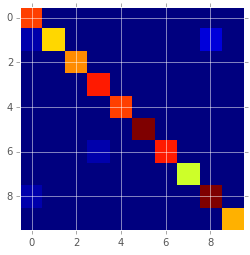

In [15]:
ys = np.array(ys, dtype=np.int32)
ys_pre = np.array(ys_pre, dtype=np.int32)

plt.imshow(confusion_matrix(ys, ys_pre), interpolation='nearest')
plt.show()

In [16]:
features = np.array(features, dtype=np.float32)
tsne_model = TSNE(n_components=2).fit_transform(features)

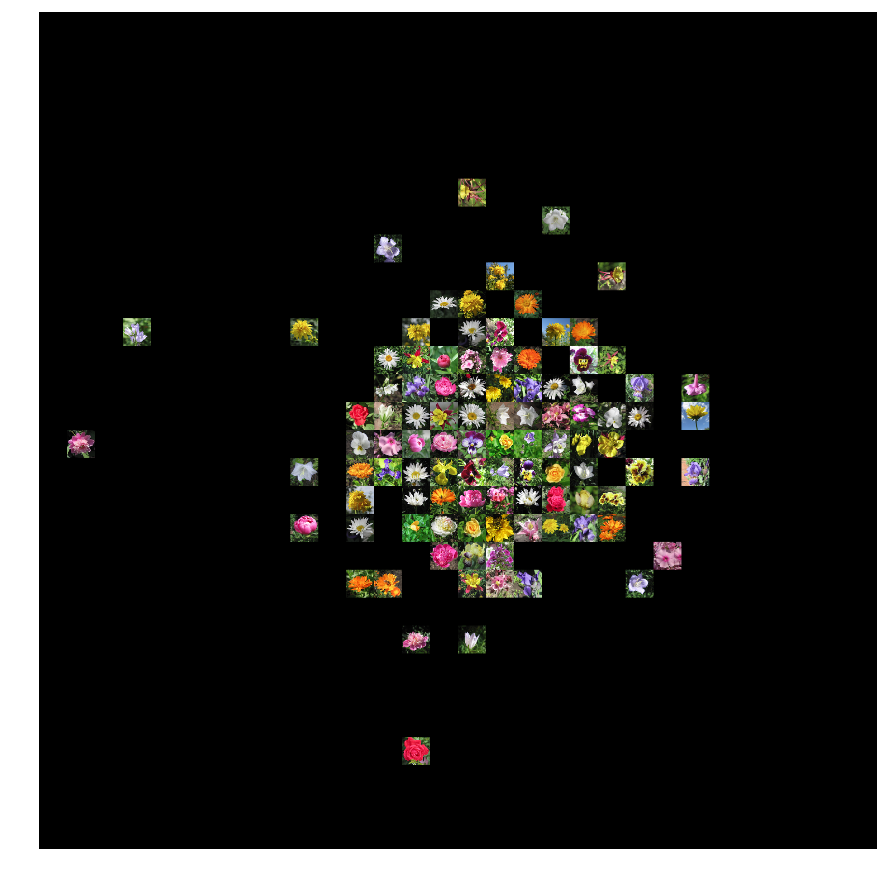

In [17]:
canvas_size = (1500, 1500)
img_size = (50, 50)
canvas = Image.new('RGB', canvas_size)

val_max = np.array(tsne_model).max()
val_min = np.array(tsne_model).min()

for i, path in enumerate(paths):
    pos_x = int(tsne_model[i][0]*(canvas_size[0]/img_size[0])/(val_max-val_min))*img_size[0]
    pos_y = int(tsne_model[i][1]*(canvas_size[1]/img_size[1])/(val_max-val_min))*img_size[1]
    pos = (int(pos_x+canvas_size[0]/2), int(pos_y+canvas_size[1]/2))
    target_img = Image.open(path)
    target_img = target_img.resize(img_size)
    canvas.paste(target_img, pos)
    target_img.close()
    
plt.figure(figsize=(15,15))
plt.imshow(np.array(canvas))
plt.axis('off')
plt.show()

In [18]:
def cos_sim_matrix(matrix):
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(axis=1, keepdims=True) ** .5
    return d / norm / norm.T

cos_sims = cos_sim_matrix(features)

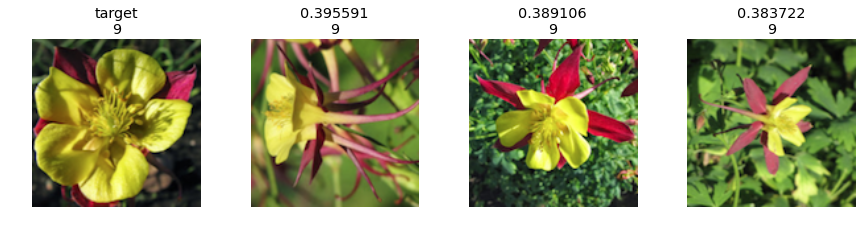

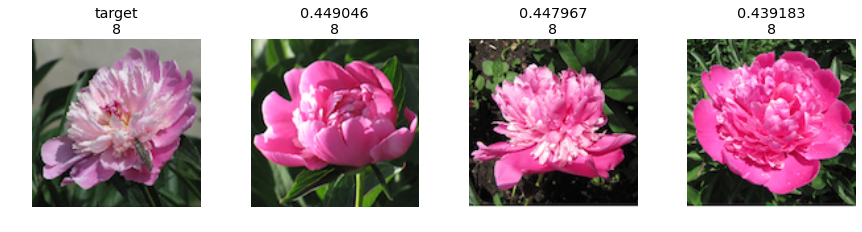

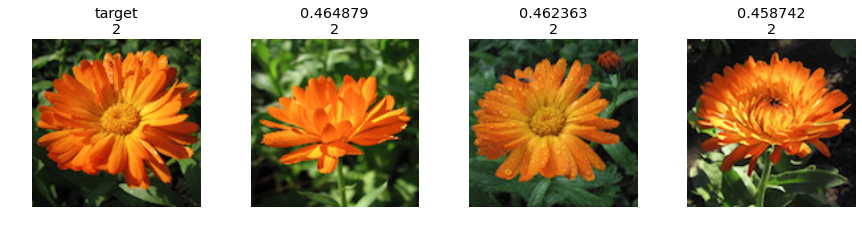

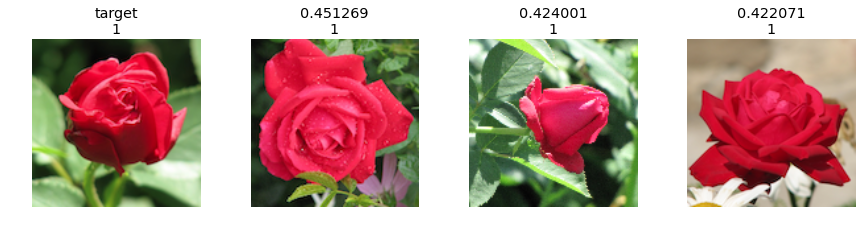

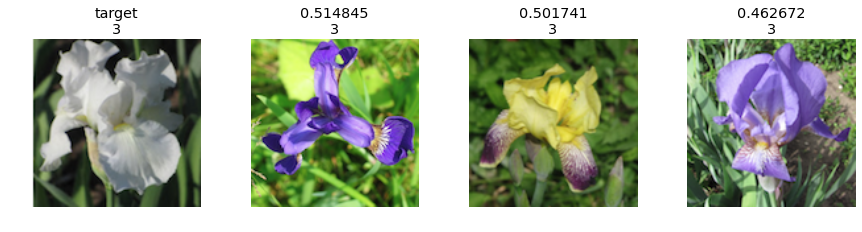

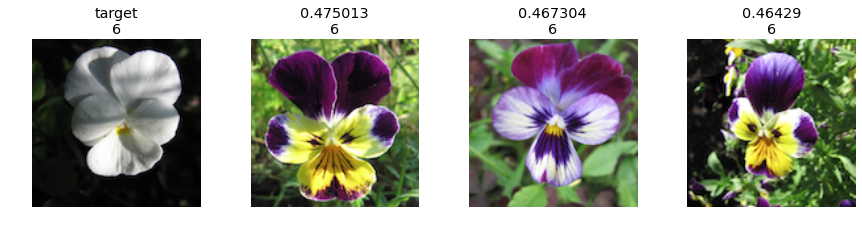

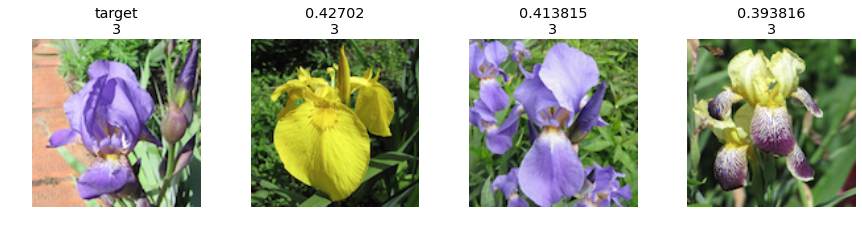

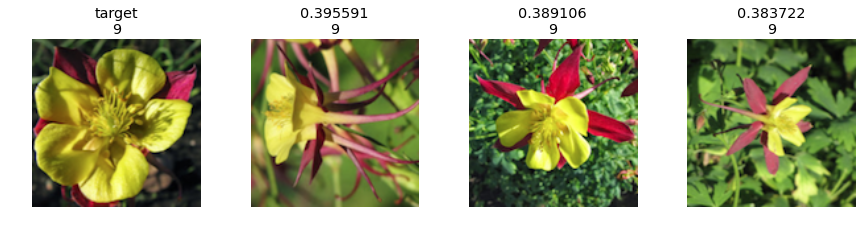

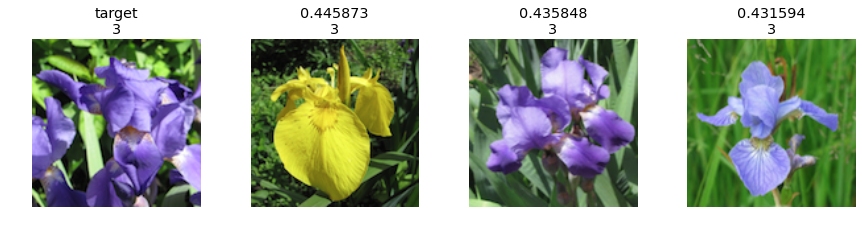

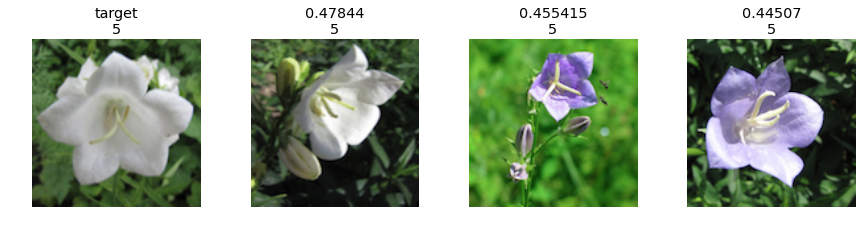

In [22]:
samples = np.random.randint(0, len(paths), 10)
for i in samples:
    sim_idxs = np.argsort(cos_sims[i])[::-1]
    sim_idxs = np.delete(sim_idxs, np.where(sim_idxs==i))
    
    sim_num = 3
    sim_idxs = sim_idxs[:sim_num]
    fig, axs = plt.subplots(ncols=sim_num+1, figsize=(15, sim_num))
    img = Image.open(paths[i])
    axs[0].imshow(img)
    axs[0].set_title('target\n'+str(labels[i]))
    axs[0].axis('off')
    
    for j in range(sim_num):
        img = Image.open(paths[sim_idxs[j]])
        axs[j+1].imshow(img)
        axs[j+1].set_title(str(cos_sims[i, sim_idxs[j]])+'\n'+str(labels[sim_idxs[j]]))
        axs[j+1].axis('off')
        
    plt.show()